## Import Library and Funcitons

In [28]:
import datetime
import logging
import numpy as np
import pandas as pd
import sklearn.metrics
import xgboost
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from ds_utils import e4
from ds_utils import aggregators
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [29]:
def mxdiff(arr):
    return np.max(np.diff(arr))

def abs_mean_change(arr):
    return np.mean(np.diff(np.abs(arr)))

def mean_change(arr):
    return np.mean(np.diff(np.abs(arr)))

def agg_lintrend(x, y):
    xs, ys = np.array_split(x, 20), np.array_split(y, 20)
    x, y = [np.mean(v) for v in xs], [np.mean(v) for v in ys]
    m, _ = np.polyfit(x, y, 1)
    return m
    
def training_from_pir(pir: int, part: int = None, base_path: str = None) -> pd.DataFrame:
    """Get training data for a person in recovery given a known base path
    Args:
        pir (int): person in recovery id number
        part (int, optional): part of the file to load. Defaults to None.
    Returns:
        pd.DataFrame: aggregated data for a person in recovery
    
    """
    agg = {
    'acc_x': [aggregators.std, mxdiff],
    'acc_y': [aggregators.std, mxdiff],
    'acc_z': [aggregators.std, mxdiff],
    'heartrate': [aggregators.mean, aggregators.std, mxdiff,aggregators.max,aggregators.min, aggregators.abs_energy, abs_mean_change],
    'conductance': [aggregators.mean, aggregators.std, mxdiff, aggregators.max, aggregators.min,aggregators.abs_energy, abs_mean_change],
    'temperature': [aggregators.mean, aggregators.std, mxdiff, aggregators.max,aggregators.min,aggregators.abs_energy, abs_mean_change],
    'bvp': [aggregators.mean, aggregators.std, mxdiff, aggregators.max, aggregators.min, aggregators.abs_energy, abs_mean_change],
    }

    print('Loading file')
    start = datetime.datetime.now()

    data = e4.read(pir, part=part, base_path=base_path).add_craving_onset(1, 0, column_name='craving_onset')
    print(f'Loading time: {(datetime.datetime.now() - start).total_seconds()}')

    start = datetime.datetime.now()
    agg_data = data.aggregate(2000, agg, ['30 min','1 h','3 h'], sample_column='craving_onset')
    print(f'Aggregation time: {(datetime.datetime.now() - start).total_seconds()}')
    
    return agg_data

def training_to_xgb(dfs) -> xgboost.XGBClassifier:
    """Pass a list of dataframes to be used as training data for an XGBoost classifier
    Args:
        dfs (list[pd.DataFrame]): a list of aggregated data dataframes
    Returns:
        xgboost.XGBClassifier: a trained classifier
    
    """
    data = pd.concat(dfs, axis=0)
    X = data.drop(columns=['craving_onset']).values
    Y = data['craving_onset'].map({True: 1, False: 0}).values

    model = xgboost.XGBClassifier(max_depth=9, subsample=0.9, colsample_bytree=0.3, objective='binary:logistic', n_estimators=400, learning_rate=0.15)
    model.fit(X, Y)

    return model

def test_xgb(df: pd.DataFrame, model: xgboost.XGBClassifier) -> np.ndarray:
    """Make predictions from a trained xgboost model on aggregated data
    Args:
        df (pd.DataFrame): test dataframe
        model (xgboost.XGBClassifier): trained model
    Returns:
        np.ndarray: the predicted values
    
    """
    X = df.drop(columns=['craving_onset']).values
    Y = df['craving_onset'].map({True: 1, False: 0}).values

    Y_pred = model.predict(X)
    predictions = [round(value) for value in Y_pred]
    accuracy = sklearn.metrics.accuracy_score(Y, Y_pred)
    precision = precision_score(Y, Y_pred, average='macro')
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Precision: %.2f%%" % (precision * 100.0))
    print(sklearn.metrics.confusion_matrix(Y, Y_pred))
    return Y_pred

def prepare_data(pir, part, agg, time_windows):
    """Prepare data for predictions on the interested emotion.The returned dataframe will include all six emotions
        The function use aggregate function in ds_util
    Args:
        pir (int): person in recovery id number
        part (int): part of the file to load
        agg (Union[Dict[str, Callable], Iterable[Dict[str, Callable]]]): a dict of functions to apply to each column, 
                with keys as column names, or a list of dicts of functions separated for each window
        time_windows (Iterable[str]): a list of a window sizes in units that can be used for resample
    Returns: 
        pd.DataFrame: data with all six emotions ready for the xgboost model (and function XGBRegressorForSurveyFast)
    """
    emotion_list = ['relaxed', 'happy', 'stressed', 'tired', 'anxious','sad']
    data = e4.read(pir, part=part, base_path='./data').add_craving_onset(1, 0, column_name='craving_onset')
    status = pd.read_parquet(f'./data/pir{pir}_status.pq', engine='auto')

    for emotion in emotion_list:
        status = status[status[emotion].first_valid_index():status[emotion].last_valid_index()]
    data = data.aggregate(700, agg, time_windows, sample_column='craving_onset')

    df = data.join(status, how='outer').sort_index()
    drop_list=['hash', 'is_craving', 'report_offset_hrs','id', 'duration_participation_s','craving_freq', 
               'need_help', 'support', 'report', 'cravings_today']
    df= df.drop(drop_list,axis=1)
    df = df[df['bvp'].first_valid_index():df['bvp'].last_valid_index()]

    for emotion in emotion_list:
        df = df[df[emotion].first_valid_index():df[emotion].last_valid_index()]

    for emotion in emotion_list:
        df[emotion] = df[emotion].ffill()

    df=df.dropna()
    
    return df

def XGBRegressorForSurveyFast (df, test, emotion, learning_rate = 0.15, max_depth = 9, colsample_bytree = 0.3,
                           subsample = 0.9):
    """predict the pir's emotions on a scale from 1 to 10  
    
    Args: 
        df (pd.DataFrame): the data set we need for the training and test data
        emotion (str): the emotion we are going to predict
        learning_rate (float): learning rate of XGB model, range [0, 1]. Defaults to 0.1
        max_depth (int): maximum depth of tree. Defaults to 5
        colsample_bytree (float): fraction of columns to be randomly sampled for each tree. Defaults to 0.3
        subsample (float): fraction of observations to be randomly sampled for each tree. Defaults to 0.8
    Return:
        xgboost.XGBRegressor: a trained regressor to predict on emotions
    """  
    
    # delete uneccessary columns
    emotionList = ['relaxed', 'happy', 'stressed', 'tired', 'anxious','sad'] 
    emotionList.remove(emotion)
    dropList = emotionList + ['craving_onset']
    df = df.drop(dropList, axis=1)
    test = test.drop(dropList, axis=1)

     # get the name of columns for features
    new_cols = [col for col in df.columns if col != emotion] + [emotion]
    df = df[new_cols]
    test = test[new_cols]
    feature_columns = new_cols[:-1]

    # Isolate the x and y variables
    y = df.iloc[:, -1].values
    X = df.iloc[:, :-1].values
    
    test_y = test.iloc[:, -1].values
    test_X = test.iloc[:, :-1].values   
    
    finalModel = xgb.XGBRegressor(objective="reg:squarederror", learning_rate = learning_rate, max_depth = max_depth,
                                  colsample_bytree = colsample_bytree, subsample = subsample, n_estimators=100,random_state=123)
    finalModel.fit(X, y)
    
    # Predictions on test dataset
    preds = finalModel.predict(test_X)
    
    # plot pred and pred-actual
    fig, ax = plt.subplots(3, 1, figsize=(12,12))
    ax[0].hist(preds, bins = 50)
    ax[1].hist(test_y, bins = 50)
    ax[2].hist(preds - test_y, bins = 50)
    ax[0].set_title('pred')
    ax[1].set_title('actual')
    ax[2].set_title('pred - actual')

    plt.show()
    
    # show results
    rmse = np.sqrt(mean_squared_error(test_y, preds))
    print("RMSE: %f" % (rmse))
    
    
    # plot feature importances
    xgb.plot_importance(finalModel, max_num_features = 10)
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()
    
    # plot true val vs. predictions
    true_val = test[emotion].values
    plt.plot(true_val)
    plt.plot(preds)
    plt.title("true val vs. predictions")
    plt.show()
    return finalModel

def df_with_emotion(df, model, emotion):
    """produce a new dataframe with predicted emotion attached to it
    
    Args: 
        df (pd.DataFrame): can be the same data used for the emotion prediction
        model (xgboost.XGBRegressor): used to produce prediction on the emotion
        emotion (str) : the emotion we are interested in
    Return:
        pd.DataFrame: a dataframe with the interested emotion attached
    """
    emotionList = ['relaxed', 'happy', 'stressed', 'tired', 'anxious','sad']
    dropList = emotionList + ['craving_onset']
    df_X = df.drop(dropList, axis=1, errors='ignore')
    df[f"pred_{emotion}"] = model.predict(df_X.values)
    df = df.drop(emotionList, axis=1, errors='ignore')
    return df


## Set parameters

In [31]:
agg = {
    'acc_x': [aggregators.std, mxdiff],
    'acc_y': [aggregators.std, mxdiff],
    'acc_z': [aggregators.std, mxdiff],
    'heartrate': [aggregators.mean, aggregators.std, mxdiff,aggregators.max,aggregators.min, aggregators.abs_energy, abs_mean_change],
    'conductance': [aggregators.mean, aggregators.std, mxdiff, aggregators.max, aggregators.min,aggregators.abs_energy, abs_mean_change],
    'temperature': [aggregators.mean, aggregators.std, mxdiff, aggregators.max,aggregators.min,aggregators.abs_energy, abs_mean_change],
    'bvp': [aggregators.mean, aggregators.std, mxdiff, aggregators.max, aggregators.min, aggregators.abs_energy, abs_mean_change],
}

time_windows = ['1 h','3 h'] 

df1 = prepare_data(89, 1, agg, time_windows)
df1.head()

ts datetime64[ns]
1 h
ts datetime64[ns]
3 h
ts datetime64[ns]


,acc_x,acc_y,acc_z,bvp,conductance,heartrate,temperature,craving_onset,acc_x_1h__std,acc_x_1h__mxdiff,...,bvp_3h__max,bvp_3h__min,bvp_3h__abs_energy,bvp_3h__abs_mean_change,relaxed,happy,stressed,tired,anxious,sad
ts,,,,,,,,,,,,,,,,,,,,,
2020-01-29 05:16:55.343750,6.0,-15.0,61.0,165.720000,0.598382,96.40,34.39,False,16.250160,147.0,...,1371.310000,-1195.520000,1.829918e+08,0.000471,6.0,6.0,7.0,7.0,7.0,5.0
2020-01-29 06:56:45.281250,50.0,7.0,37.0,-39.286667,1.843188,86.23,32.97,False,47.974810,28.0,...,857.903333,-810.363333,1.058284e+08,0.000197,6.0,6.0,7.0,7.0,7.0,5.0
2020-01-29 07:32:27.468750,-39.0,24.0,45.0,-89.710000,0.966460,85.78,34.43,False,43.904577,116.0,...,521.790000,-798.405000,1.007060e+08,0.000077,6.0,6.0,7.0,7.0,7.0,5.0
2020-01-29 08:55:52.156250,-42.0,21.0,43.0,-56.345000,0.315207,79.10,33.39,False,15.641657,56.0,...,356.515000,-309.790000,7.650137e+07,0.000266,6.0,6.0,7.0,7.0,7.0,5.0
2020-01-29 09:13:39.593750,2.0,20.0,60.0,26.863333,0.451295,75.85,33.53,False,20.709965,63.0,...,337.723333,-351.830000,6.651730e+07,0.000200,5.0,6.0,6.0,7.0,6.0,2.0


In [32]:
df2 = prepare_data(89, 2, agg, time_windows)
df3 = prepare_data( 89, 3, agg, time_windows)
test = prepare_data(89, 4, agg, time_windows)

ts datetime64[ns]
1 h
ts datetime64[ns]
3 h
ts datetime64[ns]
ts datetime64[ns]
1 h
ts datetime64[ns]
3 h
ts datetime64[ns]
ts datetime64[ns]
1 h
ts datetime64[ns]
3 h
ts datetime64[ns]


## Prediction on emotions

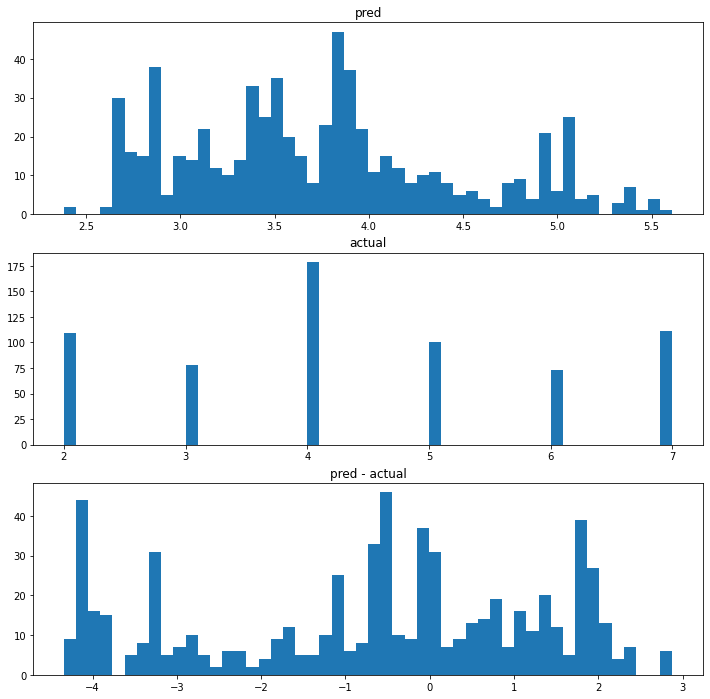

RMSE: 2.119963


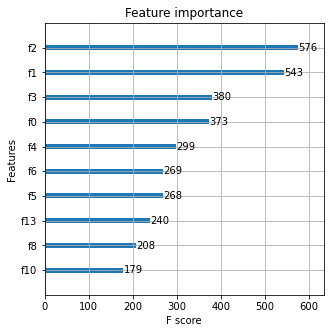

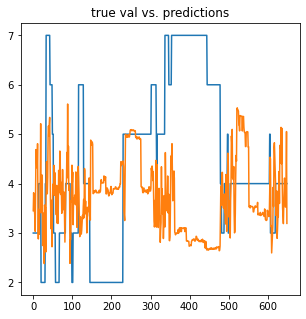

In [34]:
train = pd.concat([df1, df2, df3])
model_emotion = XGBRegressorForSurveyFast(train, test, "stressed")

In [40]:
## add train and test with predicted emotions
train_new = df_with_emotion(train, model_emotion, "stressed")
test_new = df_with_emotion(test, model_emotion, "stressed")
train_new.head()

,acc_x,acc_y,acc_z,bvp,conductance,heartrate,temperature,craving_onset,acc_x_1h__std,acc_x_1h__mxdiff,...,temperature_3h__abs_energy,temperature_3h__abs_mean_change,bvp_3h__mean,bvp_3h__std,bvp_3h__mxdiff,bvp_3h__max,bvp_3h__min,bvp_3h__abs_energy,bvp_3h__abs_mean_change,pred_stressed
ts,,,,,,,,,,,,,,,,,,,,,
2020-01-29 05:16:55.343750,6.0,-15.0,61.0,165.720000,0.598382,96.40,34.39,False,16.250160,147.0,...,1.049552e+07,4.826403e-05,-0.594121,130.020413,1612.630000,1371.310000,-1195.520000,1.829918e+08,0.000471,0
2020-01-29 06:56:45.281250,50.0,7.0,37.0,-39.286667,1.843188,86.23,32.97,False,47.974810,28.0,...,1.136727e+07,5.439831e-06,0.518146,102.768651,483.176667,857.903333,-810.363333,1.058284e+08,0.000197,0
2020-01-29 07:32:27.468750,-39.0,24.0,45.0,-89.710000,0.966460,85.78,34.43,False,43.904577,116.0,...,1.161466e+07,6.134277e-06,-0.867627,100.692794,483.176667,521.790000,-798.405000,1.007060e+08,0.000077,0
2020-01-29 08:55:52.156250,-42.0,21.0,43.0,-56.345000,0.315207,79.10,33.39,False,15.641657,56.0,...,1.141686e+07,-3.125009e-06,-0.112266,87.032474,191.120000,356.515000,-309.790000,7.650137e+07,0.000266,0
2020-01-29 09:13:39.593750,2.0,20.0,60.0,26.863333,0.451295,75.85,33.53,False,20.709965,63.0,...,1.128957e+07,-2.893527e-07,0.023825,81.220499,191.120000,337.723333,-351.830000,6.651730e+07,0.000200,0


## prediction on craving_onset

In [38]:
# train the model with prediction on emotion added
model_craving = training_to_xgb([train_new])
preds = test_xgb(test_new, model_craving)

/Users/yangtian/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 45.85%
Precision: 22.99%
[[298   2]
 [350   0]]


In [53]:
## Print feature importance
importance = model.feature_importances_
names = train_new.columns
found_index = np.in1d(names, 'craving_onset').nonzero()[0]
names = np.delete(names, found_index)
dataset = pd.DataFrame({'importance': importance, 'names': list(names)}, columns=['importance', 'names'])
dataset.sort_values(by=['importance'], inplace=True, ascending=False)
dataset.head(10)

,importance,names
65,0.047125,conductance_3h__abs_energy
62,0.044927,conductance_3h__mxdiff
31,0.041207,temperature_1h__std
54,0.038017,heartrate_3h__std
69,0.035673,temperature_3h__mxdiff
44,0.027487,acc_x_3h__std
25,0.026479,conductance_1h__mxdiff
70,0.026028,temperature_3h__max
30,0.023888,temperature_1h__mean
64,0.023387,conductance_3h__min
